<a href="https://colab.research.google.com/github/HazelvdW/context-framed-listening/blob/main/framed_listening_Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Framed Listening: **Word2Vec analyses**
> By **Hazel A. van der Walle** (PhD student, Music, Durham University), September 2025.

This notebook analyses semantic similarity between music-evoked thought (MET)
descriptions to answer: "Does context cue influence METs more than the music itself?"

Analysis approach:
- Works with individual thought descriptions (N=1962) and aggregated documents (called "METdocs")
- Calculates pairwise cosine similarities between all individual thoughts and between METdocs
- Categorises pairs by their stimuli conditions to compare similarity distributions
- Tests whether thoughts are more similar when sharing music vs sharing context

Key comparisons:
1. Same clip + different context VS Different clip + same context
   → Does music or context drive thought similarity?
2. Within vs between genre/context/clip conditions
   → What factors influence semantic coherence in METs?

---

All datasets generated and used for this study are openly available on GitHub https://github.com/HazelvdW/context-framed-listening.

In [1]:
!rm -r context-framed-listening
# Clone the GitHub repository
!git clone https://github.com/HazelvdW/context-framed-listening.git

rm: cannot remove 'context-framed-listening': No such file or directory
Cloning into 'context-framed-listening'...
remote: Enumerating objects: 391, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 391 (delta 1), reused 0 (delta 0), pack-reused 384 (from 3)
Receiving objects: 100% (391/391), 123.50 MiB | 20.32 MiB/s, done.
Resolving deltas: 100% (174/174), done.


Refresh files to see **"context-framed-listening"**.


---

## Setup

In [2]:
import os
import csv
import pandas as pd
import numpy as np

!pip install gensim
import gensim
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 66.7 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


The Github repo for Word2Vec model pretrained trained on Google News was accessed via https://github.com/mmihaltz/word2vec-GoogleNews-vectors/ (September 2025).
>I downloaded `GoogleNews-vectors-negative300.bin.gz` to my Google Drive for use here.

>You can follow the commented out code below to mount your Drive, _or_ you can mount it manually by selecting the File icon on the left-side menu followed by the drive symbol next the 'Refresh'. [Change the pathname as needed.]

Load up the pretrained Google word2vec embeddings:

In [3]:
from google.colab import drive
drive.mount('/content/drive') # < this will ask you to log into your account

# Load the pretrained Google Word2Vec model
print("Loading Word2Vec model...")
model_word2vec = gensim.models.KeyedVectors.load_word2vec_format(
    '/content/drive/MyDrive/Colab Notebooks/W2V_TFIDF/GoogleNews-vectors-negative300.bin.gz',
    binary=True
)
model_word2vec.fill_norms() # < normalises loaded word vectors (ensures vector lengths don't affect sim calcs)
print("Model loaded successfully!\n")


# Get W2V embeddings for OOV words
def get_word2vec_embedding(text, model):
    """
    Get Word2Vec embedding for text by averaging word vectors.
    Handles words not in vocabulary.
    """
    word_vectors = []
    words_not_in_vocab = []

    tokens = nltk.word_tokenize(str(text))

    for word in tokens:
        try:
            word_vectors.append(model[word])
        except KeyError:
            words_not_in_vocab.append(word)

    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0), words_not_in_vocab
    else:
        return np.zeros(300), words_not_in_vocab

Mounted at /content/drive
Loading Word2Vec model...
Model loaded successfully!



Load in the data file "**dataMET_preprocessed.csv**" that contains the preprocessed text data of participants' thought desciptions, generated using the code notebook titled [framed_listening_text_prep](https://github.com/HazelvdW/context-framed-listening/blob/main/framed_listening_text_prep.ipynb)

In [4]:
print("Loading preprocessed MET data...")
dataMETpre = pd.read_csv("/content/context-framed-listening/NLP_outputs/dataMET_preprocessed.csv")

# Use the Word2Vec-appropriate preprocessing column (aggressive filtering)
thought_column = 'METdescr_prepLVL2'

print(f"Total individual MET descriptions for analysis: {len(dataMETpre)}")
print(f"Unique clips: {dataMETpre['clip_name'].nunique()}")
print(f"Unique contexts: {dataMETpre['context_word'].nunique()}")
print(f"Unique clip-context pairs: {dataMETpre['clip_context_PAIR'].nunique()}")

Loading preprocessed MET data...
Total individual MET descriptions for analysis: 1962
Unique clips: 16
Unique contexts: 4
Unique clip-context pairs: 64


---
## ANALYSIS AT INDIVIDUAL MET LEVEL


### Word2Vec embeddings

In [5]:
print("\nComputing Word2Vec embeddings for individual thoughts...")
print("This may take several minutes for ~2000 thoughts...")

embeddings = []
all_missing_words = []

for idx, row in dataMETpre.iterrows():
    text = str(row[thought_column])
    embedding, missing_words = get_word2vec_embedding(text, model_word2vec)
    embeddings.append(embedding)
    all_missing_words.extend(missing_words)

    if (idx + 1) % 200 == 0:
        print(f"  Processed {idx + 1}/{len(dataMETpre)} thoughts...")

embeddings = np.array(embeddings)
print(f"\nWord2Vec embeddings shape: {embeddings.shape}")
print(f"Unique words not in vocabulary: {len(set(all_missing_words))}")

# Save embeddings for reuse
np.save('/content/context-framed-listening/NLP_outputs/Word2Vec/indvMET_embeddings_W2V.npy',
        embeddings)
print("Embeddings saved")


Computing Word2Vec embeddings for individual thoughts...
This may take several minutes for ~2000 thoughts...
  Processed 200/1962 thoughts...
  Processed 400/1962 thoughts...
  Processed 600/1962 thoughts...
  Processed 800/1962 thoughts...
  Processed 1000/1962 thoughts...
  Processed 1200/1962 thoughts...
  Processed 1400/1962 thoughts...
  Processed 1600/1962 thoughts...
  Processed 1800/1962 thoughts...

Word2Vec embeddings shape: (1962, 300)
Unique words not in vocabulary: 145
Embeddings saved


### Pairwise Cosine Similarity

In [6]:
print("\nCalculating pairwise cosine similarity matrix...")
print(f"This creates a {len(dataMETpre)} x {len(dataMETpre)} matrix...")

cosine_matrix = cosine_similarity(embeddings, embeddings)

# Save full similarity matrix
cosine_df = pd.DataFrame(
    cosine_matrix,
    index=dataMETpre.index,
    columns=dataMETpre.index
)
cosine_df.to_csv('/content/context-framed-listening/NLP_outputs/Word2Vec/indvMET_cosine_matrix_W2V.csv')
print("Cosine similarity matrix saved")


Calculating pairwise cosine similarity matrix...
This creates a 1962 x 1962 matrix...
Cosine similarity matrix saved


### Similarity Values by Condition

In [7]:
print("\nExtracting similarity values for each condition...")

# Initialize storage for similarity measures
similarity_data = {
    'thought_i': [],
    'thought_j': [],
    'similarity': [],
    'same_clip': [],
    'same_context': [],
    'same_genre': [],
    'same_participant': [],
    'condition': []
}

# Extract metadata for efficient comparison
clips = dataMETpre['clip_name'].values
contexts = dataMETpre['context_word'].values
genres = dataMETpre['clip_genre'].values
participants = dataMETpre['participant_id'].values if 'participant_id' in dataMETpre.columns else np.zeros(len(dataMETpre))

# Iterate through upper triangle of similarity matrix (avoid duplicates)
n_thoughts = len(dataMETpre)
total_pairs = (n_thoughts * (n_thoughts - 1)) // 2
print(f"Processing {total_pairs:,} unique thought pairs...")

for i in range(n_thoughts):
    if (i + 1) % 200 == 0:
        print(f"  Processed {i + 1}/{n_thoughts} thoughts...")

    for j in range(i + 1, n_thoughts):
        # Extract similarity value
        sim_value = cosine_matrix[i, j]

        # Determine conditions
        same_clip = clips[i] == clips[j]
        same_context = contexts[i] == contexts[j]
        same_genre = genres[i] == genres[j]
        same_participant = participants[i] == participants[j]

        # Categorize into primary conditions for the research question
        if same_clip and same_context:
            condition = 'sameClip_sameContext'
        elif same_clip and not same_context:
            condition = 'sameClip_diffContext'  # KEY: Music influence
        elif not same_clip and same_context:
            condition = 'diffClip_sameContext'  # KEY: Context influence
        elif not same_clip and not same_context:
            if same_genre:
                condition = 'diffClip_diffContext_sameGenre'
            else:
                condition = 'diffClip_diffContext_diffGenre'

        # Store data
        similarity_data['thought_i'].append(i)
        similarity_data['thought_j'].append(j)
        similarity_data['similarity'].append(sim_value)
        similarity_data['same_clip'].append(same_clip)
        similarity_data['same_context'].append(same_context)
        similarity_data['same_genre'].append(same_genre)
        similarity_data['same_participant'].append(same_participant)
        similarity_data['condition'].append(condition)

# Create DataFrame
sim_df = pd.DataFrame(similarity_data)
sim_df.to_csv('/content/context-framed-listening/NLP_outputs/Word2Vec/indvMET_similarity_by_condition_W2V.csv',
              index=False)

print("\nSimilarity measures extracted")
print("\nCondition summary:")
print(sim_df.groupby('condition')['similarity'].agg(['count', 'mean', 'std', 'min', 'max']))



Extracting similarity values for each condition...
Processing 1,923,741 unique thought pairs...
  Processed 200/1962 thoughts...
  Processed 400/1962 thoughts...
  Processed 600/1962 thoughts...
  Processed 800/1962 thoughts...
  Processed 1000/1962 thoughts...
  Processed 1200/1962 thoughts...
  Processed 1400/1962 thoughts...
  Processed 1600/1962 thoughts...
  Processed 1800/1962 thoughts...

Similarity measures extracted

Condition summary:
                                  count      mean       std       min      max
condition                                                                     
diffClip_diffContext_diffGenre  1082516  0.419962  0.137090 -0.104916  1.00000
diffClip_diffContext_sameGenre   270501  0.426750  0.138515 -0.078487  1.00000
diffClip_sameContext             450875  0.425183  0.138493 -0.099242  1.00000
sameClip_diffContext              90474  0.436348  0.141248 -0.100081  0.89746
sameClip_sameContext              29375  0.442375  0.142658 -0.071264  1.000

### STATISTICAL ANALYSES

1. PRIMARY RESEARCH QUESTION: Music vs Context Influence
2. Genre Effects
3. Context Specificity
4. Music Specificity
5. OMNIBUS TEST
6. Effect Size Ranking

In [8]:
def compare_conditions(df, cond1, cond2, label1, label2):
    """Compare two conditions with t-test and effect size."""
    data1 = df[df['condition'] == cond1]['similarity']
    data2 = df[df['condition'] == cond2]['similarity']

    t_stat, p_value = stats.ttest_ind(data1, data2)

    # Cohen's d
    pooled_std = np.sqrt((data1.std()**2 + data2.std()**2) / 2)
    effect_size = (data1.mean() - data2.mean()) / pooled_std

    if p_value < 0.001:
        sig_str = "***"
    elif p_value < 0.01:
        sig_str = "**"
    elif p_value < 0.05:
        sig_str = "*"
    else:
        sig_str = "n.s."

    return {
        'comparison': f"{label1} vs {label2}",
        'mean1': data1.mean(),
        'mean2': data2.mean(),
        'diff': data1.mean() - data2.mean(),
        't': t_stat,
        'p': p_value,
        'sig': sig_str,
        'd': effect_size,
        'n1': len(data1),
        'n2': len(data2)
    }

# Store all comparison results
comparisons = []


# 1. PRIMARY RESEARCH QUESTION: Music vs Context Influence
# ----------------------------------------------------------------------------
print("\n1. PRIMARY QUESTION: Music vs Context Influence")
print("-" * 70)

comp = compare_conditions(
    sim_df,
    'sameClip_diffContext',
    'diffClip_sameContext',
    'Same Music, Diff Context',
    'Diff Music, Same Context'
)
comparisons.append(comp)

print(f"\nSame music, different context: M={comp['mean1']:.4f} (N={comp['n1']})")
print(f"Different music, same context: M={comp['mean2']:.4f} (N={comp['n2']})")
print(f"Difference: {comp['diff']:.4f}")
print(f"t({comp['n1'] + comp['n2'] - 2}) = {comp['t']:.3f}, p = {comp['p']:.4f} {comp['sig']}")
print(f"Cohen's d = {comp['d']:.3f}")

if comp['mean1'] > comp['mean2']:
    print("\n→ MUSIC drives thought similarity MORE than context")
else:
    print("\n→ CONTEXT drives thought similarity MORE than music")


# 2. GENRE EFFECTS
# ----------------------------------------------------------------------------
print("\n\n2. GENRE EFFECTS")
print("-" * 70)

comp = compare_conditions(
    sim_df,
    'diffClip_diffContext_sameGenre',
    'diffClip_diffContext_diffGenre',
    'Different everything, Same Genre',
    'Different everything, Different Genre'
)
comparisons.append(comp)

print(f"\nSame genre (diff clip & context): M={comp['mean1']:.4f} (N={comp['n1']})")
print(f"Different genre (diff clip & context): M={comp['mean2']:.4f} (N={comp['n2']})")
print(f"t = {comp['t']:.3f}, p = {comp['p']:.4f} {comp['sig']}, d = {comp['d']:.3f}")

if comp['sig'] != 'n.s.':
    print("\n→ Genre creates semantic coherence even across different clips and contexts")
else:
    print("\n→ Genre does NOT significantly affect thought similarity")


# 3. CONTEXT SPECIFICITY
# ----------------------------------------------------------------------------
print("\n\n3. CONTEXT SPECIFICITY: How much does context alone matter?")
print("-" * 70)

comp = compare_conditions(
    sim_df,
    'sameClip_sameContext',
    'diffClip_sameContext',
    'Same Context & Same Clip',
    'Same Context, Diff Clip'
)
comparisons.append(comp)

print(f"\nSame context + same clip: M={comp['mean1']:.4f} (N={comp['n1']})")
print(f"Same context, different clip: M={comp['mean2']:.4f} (N={comp['n2']})")
print(f"t = {comp['t']:.3f}, p = {comp['p']:.4f} {comp['sig']}, d = {comp['d']:.3f}")

print("\n→ This shows whether identical stimuli create MORE similarity than just shared context")


# 4. MUSIC SPECIFICITY
# ----------------------------------------------------------------------------
print("\n\n4. MUSIC SPECIFICITY: How much does the specific clip alone matter?")
print("-" * 70)

comp = compare_conditions(
    sim_df,
    'sameClip_sameContext',
    'sameClip_diffContext',
    'Same Clip & Same Context',
    'Same Clip, Diff Context'
)
comparisons.append(comp)

print(f"\nSame clip + same context: M={comp['mean1']:.4f} (N={comp['n1']})")
print(f"Same clip, different context: M={comp['mean2']:.4f} (N={comp['n2']})")
print(f"t = {comp['t']:.3f}, p = {comp['p']:.4f} {comp['sig']}, d = {comp['d']:.3f}")

print("\n→ This shows whether identical stimuli create MORE similarity than just shared music")


# 5. OMNIBUS TEST
# ----------------------------------------------------------------------------
print("\n\n5. OMNIBUS TEST: Do conditions differ overall?")
print("-" * 70)

conditions = sim_df['condition'].unique()
groups = [sim_df[sim_df['condition'] == cond]['similarity'] for cond in conditions]
f_stat, p_anova = stats.f_oneway(*groups)

print(f"\nOne-way ANOVA across all {len(conditions)} conditions:")
print(f"F({len(conditions)-1}, {len(sim_df)-len(conditions)}) = {f_stat:.3f}, p = {p_anova:.4e}")

if p_anova < 0.001:
    print("\n→ Conditions are HIGHLY significantly different overall")
else:
    print("\n→ Conditions show significant differences" if p_anova < 0.05 else "→ No significant differences")


# 6. EFFECT SIZE RANKING
# ----------------------------------------------------------------------------
print("\n\n6. EFFECT SIZE RANKING: Which comparisons matter most?")
print("-" * 70)

condition_means = sim_df.groupby('condition')['similarity'].agg(['mean', 'std', 'count'])
condition_means = condition_means.sort_values('mean', ascending=False)

print("\nCondition means (ranked):")
print(condition_means)

# Save comparison results
comparisons_df = pd.DataFrame(comparisons)
comparisons_df = comparisons_df.sort_values('d', key=abs, ascending=False)
comparisons_df.to_csv('/content/context-framed-listening/NLP_outputs/Word2Vec/indvMET_statistical_comparisons_W2V.csv', index=False)

print("\n\nKey comparisons ranked by effect size:")
print(comparisons_df[['comparison', 'diff', 'd', 'p', 'sig']])


1. PRIMARY QUESTION: Music vs Context Influence
----------------------------------------------------------------------

Same music, different context: M=0.4363 (N=90474)
Different music, same context: M=0.4252 (N=450875)
Difference: 0.0112
t(541347) = 22.057, p = 0.0000 ***
Cohen's d = 0.080

→ MUSIC drives thought similarity MORE than context


2. GENRE EFFECTS
----------------------------------------------------------------------

Same genre (diff clip & context): M=0.4268 (N=270501)
Different genre (diff clip & context): M=0.4200 (N=1082516)
t = 22.989, p = 0.0000 ***, d = 0.049

→ Genre creates semantic coherence even across different clips and contexts


3. CONTEXT SPECIFICITY: How much does context alone matter?
----------------------------------------------------------------------

Same context + same clip: M=0.4424 (N=29375)
Same context, different clip: M=0.4252 (N=450875)
t = 20.577, p = 0.0000 ***, d = 0.122

→ This shows whether identical stimuli create MORE similarity tha

### Visualisations

1. PRIMARY COMPARISON: Music vs Context
2. ALL CONDITIONS comparison
3. Bar plot with means and 95% CI
4. Distribution comparison histogram (Music vs Context)
5. HIERARCHICAL comparison showing all levels
6. Genre effects visualisation
7. Heatmap showing mean similarities between conditions


Generating visualisations...


/tmp/ipython-input-2917680077.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Same Music\nDifferent Context', 'Different Music\nSame Context'])


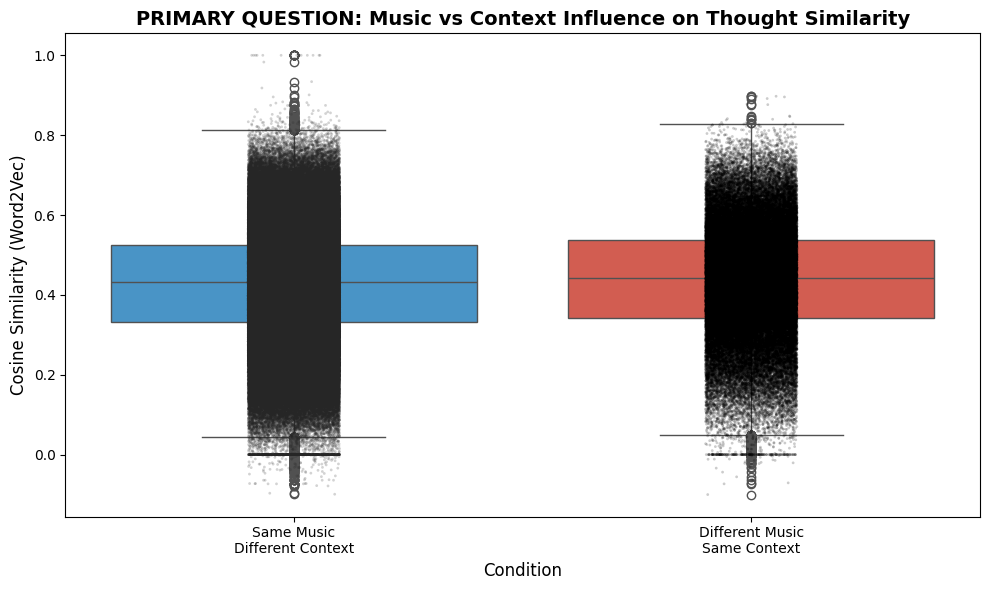

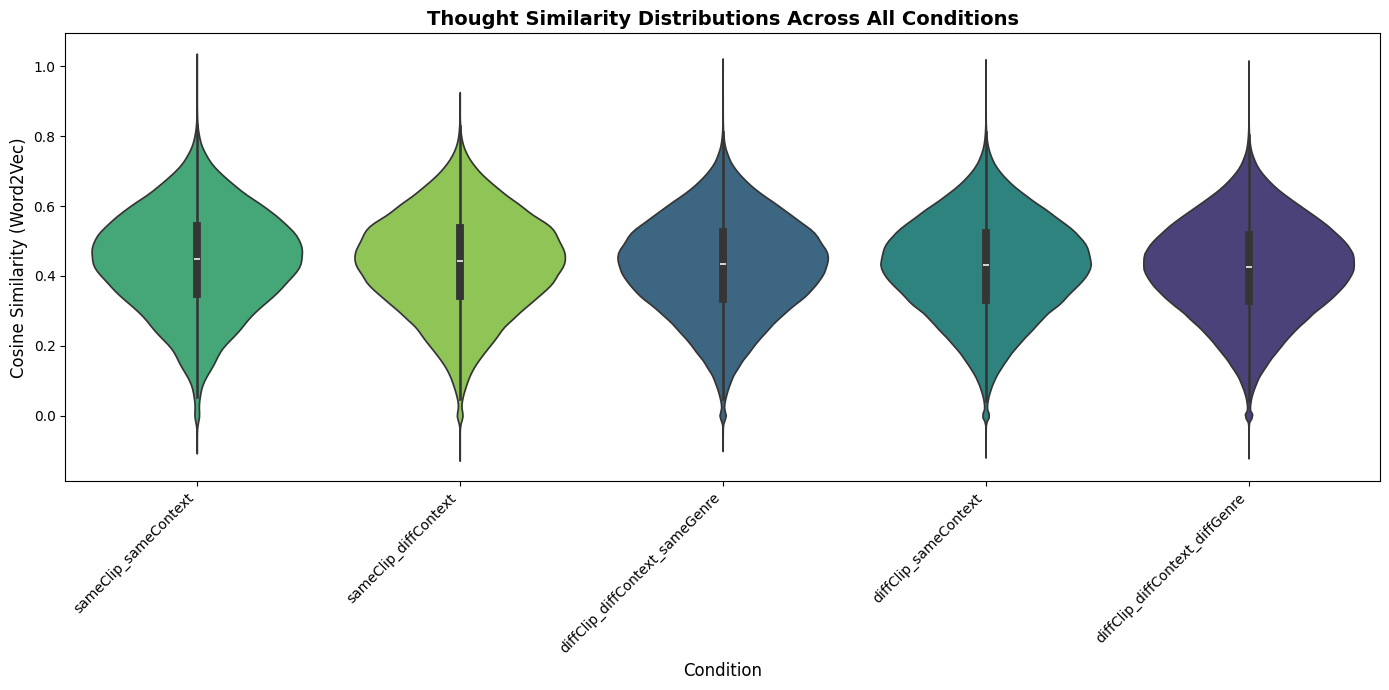

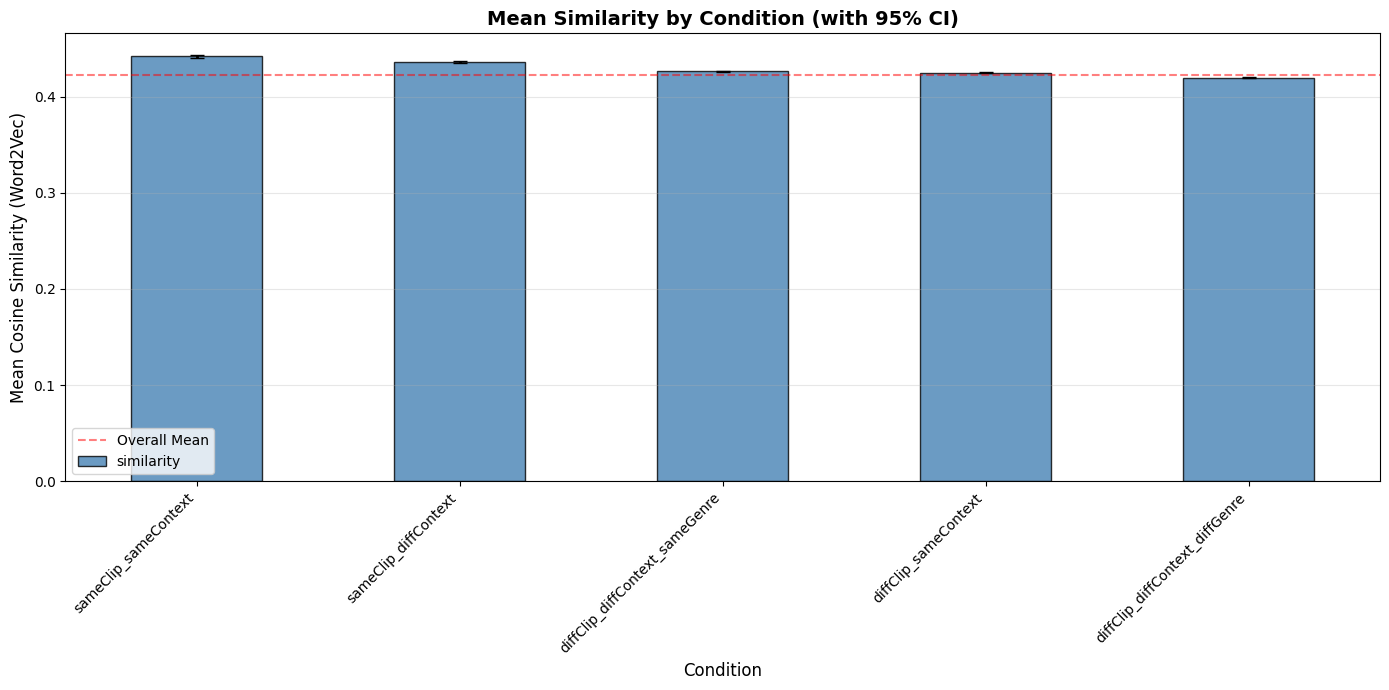

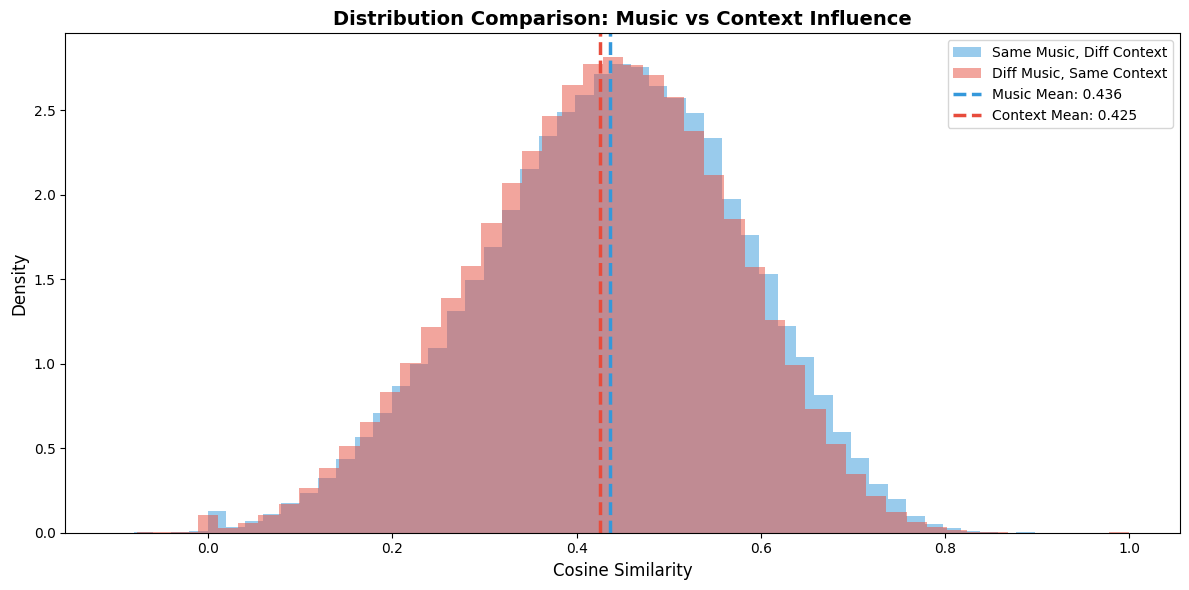

/tmp/ipython-input-2917680077.py:97: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=0, ha='center')


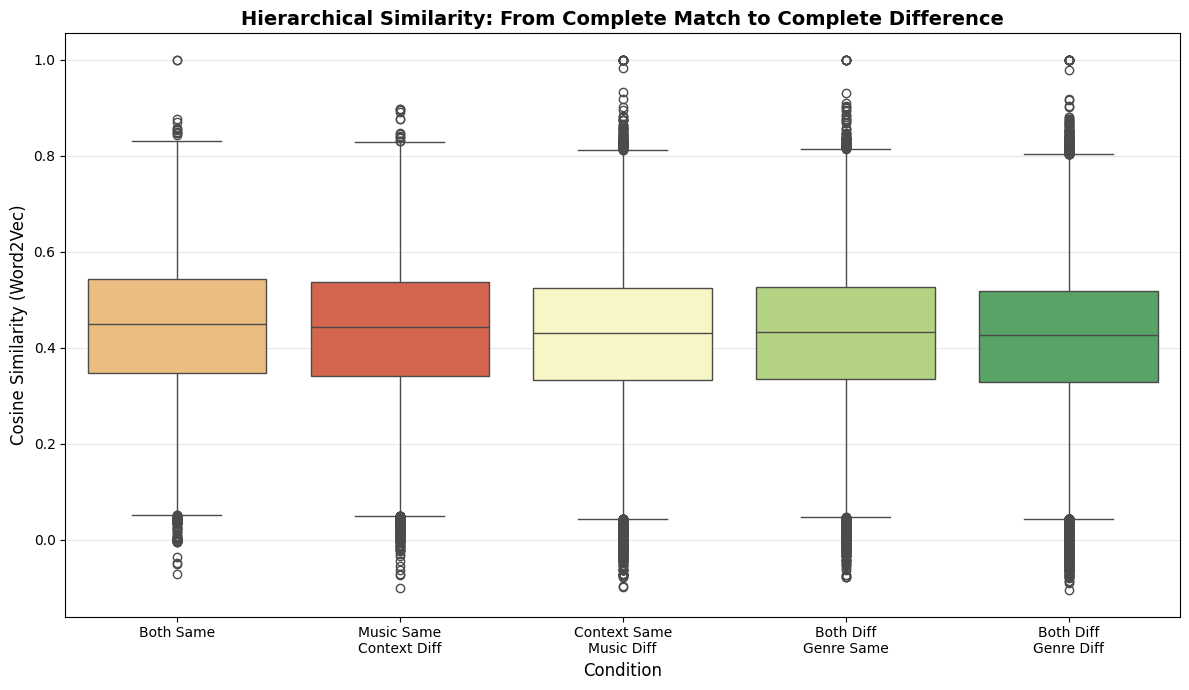

/tmp/ipython-input-2917680077.py:118: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['Same Genre', 'Different Genre'])


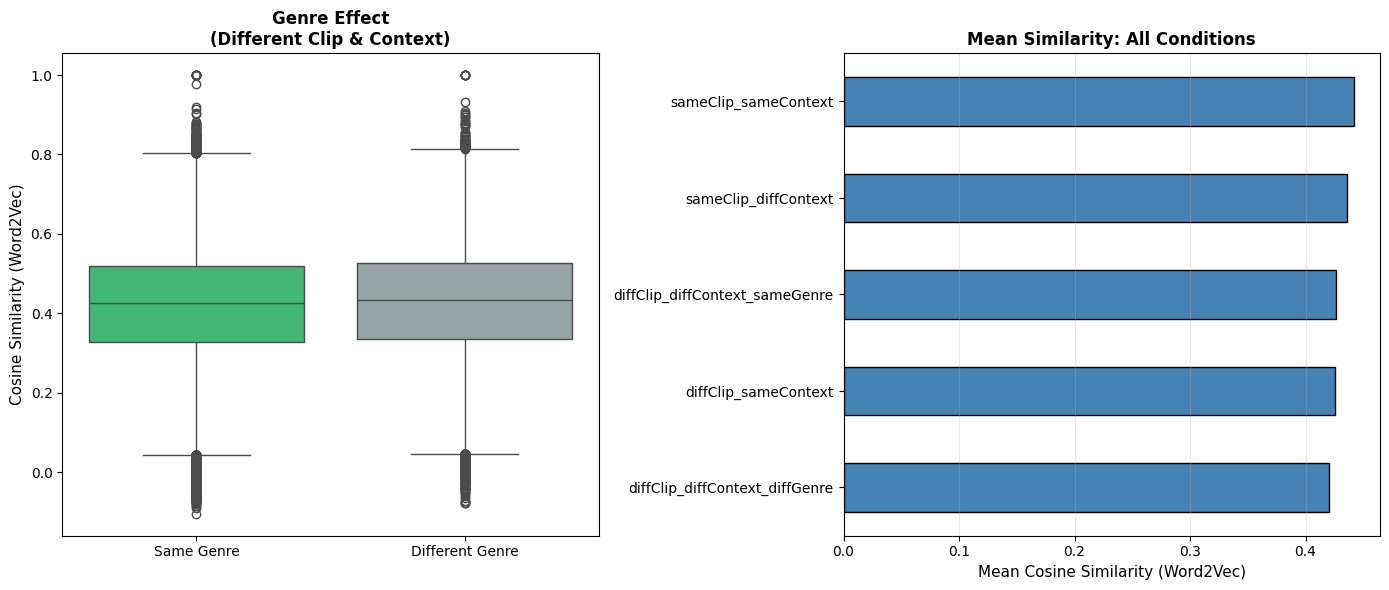

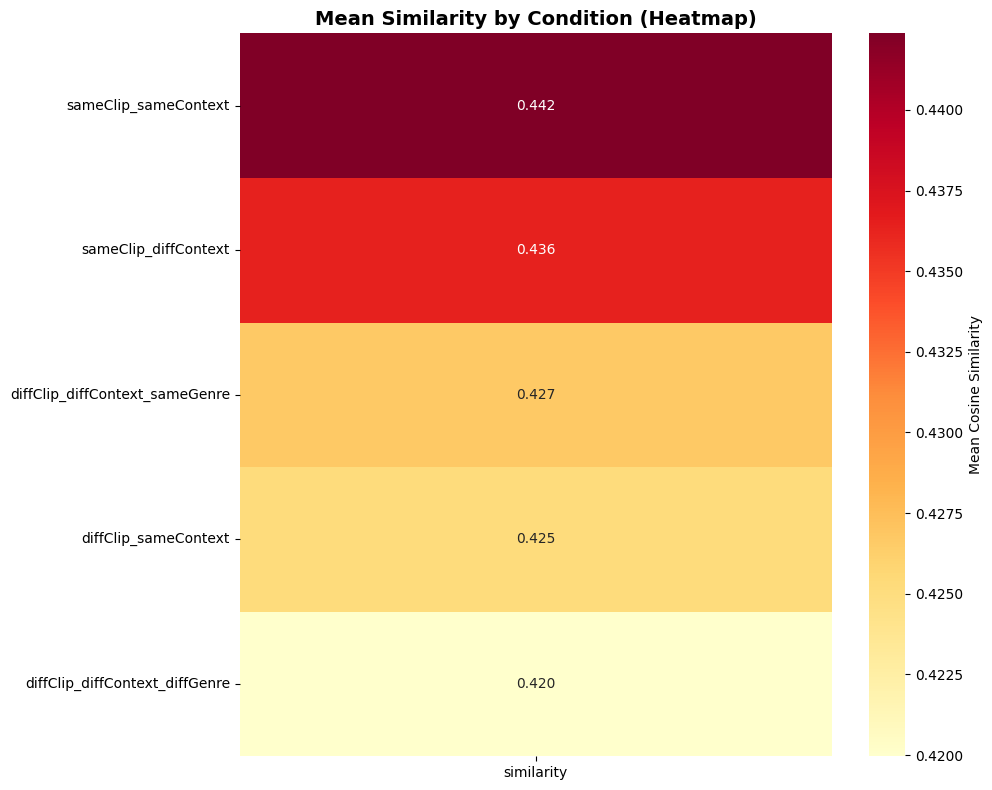

In [9]:
print("\nGenerating visualisations...")

# Get data for key conditions
music_driven = sim_df[sim_df['condition'] == 'sameClip_diffContext']['similarity']
context_driven = sim_df[sim_df['condition'] == 'diffClip_sameContext']['similarity']
same_both = sim_df[sim_df['condition'] == 'sameClip_sameContext']['similarity']
diff_both_same_genre = sim_df[sim_df['condition'] == 'diffClip_diffContext_sameGenre']['similarity']
diff_both_diff_genre = sim_df[sim_df['condition'] == 'diffClip_diffContext_diffGenre']['similarity']


# 1. PRIMARY COMPARISON: Music vs Context
fig, ax = plt.subplots(figsize=(10, 6))
comparison_data = sim_df[sim_df['condition'].isin(['sameClip_diffContext', 'diffClip_sameContext'])]
sns.boxplot(data=comparison_data, x='condition', y='similarity', ax=ax,
            hue='condition', palette=['#3498db', '#e74c3c'])
sns.stripplot(data=comparison_data, x='condition', y='similarity', ax=ax,
              hue='condition', palette='dark:black', alpha=0.2, size=2)
ax.set_title('PRIMARY QUESTION: Music vs Context Influence on Thought Similarity',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Condition', fontsize=12)
ax.set_ylabel('Cosine Similarity (Word2Vec)', fontsize=12)
ax.set_xticklabels(['Same Music\nDifferent Context', 'Different Music\nSame Context'])
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/Word2Vec/indvMET_01_music_vs_context_boxplot_W2V.png',
            dpi=300, bbox_inches='tight')
plt.show()

# 2. ALL CONDITIONS comparison
fig, ax = plt.subplots(figsize=(14, 7))
condition_order = sim_df.groupby('condition')['similarity'].mean().sort_values(ascending=False).index
sns.violinplot(data=sim_df, x='condition', y='similarity', ax=ax, order=condition_order,
               hue='condition', palette='viridis')
ax.set_title('Thought Similarity Distributions Across All Conditions', fontsize=14, fontweight='bold')
ax.set_xlabel('Condition', fontsize=12)
ax.set_ylabel('Cosine Similarity (Word2Vec)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/Word2Vec/indvMET_02_all_conditions_violin_W2V.png',
            dpi=300, bbox_inches='tight')
plt.show()

# 3. Bar plot with means and 95% CI
fig, ax = plt.subplots(figsize=(14, 7))
means = sim_df.groupby('condition')['similarity'].mean().sort_values(ascending=False)
sems = sim_df.groupby('condition')['similarity'].sem()
ci95 = sems * 1.96

means.plot(kind='bar', ax=ax, yerr=ci95, capsize=5, color='steelblue',
           edgecolor='black', alpha=0.8, error_kw={'linewidth': 2})
ax.set_title('Mean Similarity by Condition (with 95% CI)', fontsize=14, fontweight='bold')
ax.set_xlabel('Condition', fontsize=12)
ax.set_ylabel('Mean Cosine Similarity (Word2Vec)', fontsize=12)
ax.set_xticklabels(means.index, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)
ax.axhline(y=sim_df['similarity'].mean(), color='red', linestyle='--',
           alpha=0.5, label='Overall Mean')
ax.legend()
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/Word2Vec/indvMET_03_condition_means_barplot_W2V.png',
            dpi=300, bbox_inches='tight')
plt.show()

# 4. Distribution comparison histogram (Music vs Context)
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(music_driven, bins=50, alpha=0.5, label='Same Music, Diff Context', color='#3498db', density=True)
ax.hist(context_driven, bins=50, alpha=0.5, label='Diff Music, Same Context', color='#e74c3c', density=True)
ax.axvline(music_driven.mean(), color='#3498db', linestyle='--', linewidth=2.5,
           label=f'Music Mean: {music_driven.mean():.3f}')
ax.axvline(context_driven.mean(), color='#e74c3c', linestyle='--', linewidth=2.5,
           label=f'Context Mean: {context_driven.mean():.3f}')
ax.set_xlabel('Cosine Similarity', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Distribution Comparison: Music vs Context Influence', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/Word2Vec/indvMET_04_music_vs_context_histogram_W2V.png',
            dpi=300, bbox_inches='tight')
plt.show()

# 5. HIERARCHICAL comparison showing all levels
fig, ax = plt.subplots(figsize=(12, 7))
hierarchical_data = sim_df[sim_df['condition'].isin([
    'sameClip_sameContext',
    'sameClip_diffContext',
    'diffClip_sameContext',
    'diffClip_diffContext_sameGenre',
    'diffClip_diffContext_diffGenre'
])]

order = ['sameClip_sameContext', 'sameClip_diffContext', 'diffClip_sameContext',
         'diffClip_diffContext_sameGenre', 'diffClip_diffContext_diffGenre']
labels = ['Both Same', 'Music Same\nContext Diff', 'Context Same\nMusic Diff',
          'Both Diff\nGenre Same', 'Both Diff\nGenre Diff']

sns.boxplot(data=hierarchical_data, x='condition', y='similarity', ax=ax,
            order=order, hue='condition', palette='RdYlGn_r')
ax.set_xticklabels(labels, rotation=0, ha='center')
ax.set_title('Hierarchical Similarity: From Complete Match to Complete Difference',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Condition', fontsize=12)
ax.set_ylabel('Cosine Similarity (Word2Vec)', fontsize=12)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/Word2Vec/indvMET_05_hierarchical_comparison_W2V.png',
            dpi=300, bbox_inches='tight')
plt.show()

# 6. Genre effects visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

genre_comparison = sim_df[sim_df['condition'].isin([
    'diffClip_diffContext_sameGenre',
    'diffClip_diffContext_diffGenre'
])]
sns.boxplot(data=genre_comparison, x='condition', y='similarity', ax=axes[0],
            hue='condition', palette=['#2ecc71', '#95a5a6'])
axes[0].set_title('Genre Effect\n(Different Clip & Context)', fontsize=12, fontweight='bold')
axes[0].set_xticklabels(['Same Genre', 'Different Genre'])
axes[0].set_ylabel('Cosine Similarity (Word2Vec)', fontsize=11)
axes[0].set_xlabel('')

all_conditions_means = sim_df.groupby('condition')['similarity'].mean()
all_conditions_means.sort_values(ascending=True).plot(kind='barh', ax=axes[1],
                                                       color='steelblue', edgecolor='black')
axes[1].set_title('Mean Similarity: All Conditions', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Mean Cosine Similarity (Word2Vec)', fontsize=11)
axes[1].set_ylabel('')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/Word2Vec/indvMET_06_genre_effects_summary_W2V.png',
            dpi=300, bbox_inches='tight')
plt.show()

# 7. Heatmap showing mean similarities between conditions
fig, ax = plt.subplots(figsize=(10, 8))
condition_pivot = sim_df.pivot_table(values='similarity',
                                      index='condition',
                                      aggfunc='mean').sort_values('similarity', ascending=False)
sns.heatmap(condition_pivot, annot=True, fmt='.3f', cmap='YlOrRd',
            cbar_kws={'label': 'Mean Cosine Similarity'}, ax=ax)
ax.set_title('Mean Similarity by Condition (Heatmap)', fontsize=14, fontweight='bold')
ax.set_ylabel('')
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/Word2Vec/indvMET_07_condition_heatmap_W2V.png',
            dpi=300, bbox_inches='tight')
plt.show()

### SUMMARY

In [10]:
print("\n" + "-"*70)
print("INDIVIDUAL-LEVEL ANALYSIS COMPLETE")
print("-"*70)

print("\nOutput files saved:")
print("\n  Data files:")
print("    - indvMET_embeddings_W2V.npy")
print("    - indvMET_cosine_matrix_W2V.csv")
print("    - indvMET_similarity_by_condition_W2V.csv")
print("    - indvMET_statistical_comparisons_W2V.csv")

print("\n  Visualisations:")
print("    - indvMET_01_music_vs_context_boxplot_W2V.png")
print("    - indvMET_02_all_conditions_violin_W2V.png")
print("    - indvMET_03_condition_means_barplot_W2V.png")
print("    - indvMET_04_music_vs_context_histogram_W2V.png")
print("    - indvMET_05_hierarchical_comparison_W2V.png")
print("    - indvMET_06_genre_effects_summary_W2V.png")
print("    - indvMET_07_condition_heatmap_W2V.png")

print("\n" + "-"*70)
print("KEY FINDINGS SUMMARY")
print("-"*70)

music_driven_summary = sim_df[sim_df['condition'] == 'sameClip_diffContext']['similarity']
context_driven_summary = sim_df[sim_df['condition'] == 'diffClip_sameContext']['similarity']
diff = music_driven_summary.mean() - context_driven_summary.mean()
t_stat, p_value = stats.ttest_ind(music_driven_summary, context_driven_summary)
effect_size = diff / np.sqrt((music_driven_summary.std()**2 + context_driven_summary.std()**2) / 2)

print("\n1. PRIMARY RESEARCH QUESTION: Music vs Context")
if abs(diff) < 0.01:
    print(f"   → Music and context have EQUIVALENT influence (d={effect_size:.3f})")
elif music_driven_summary.mean() > context_driven_summary.mean():
    print(f"   → MUSIC drives thought similarity MORE than context")
    print(f"   → Difference: {diff:.4f} (d={effect_size:.3f}, p={p_value:.4f})")
else:
    print(f"   → CONTEXT drives thought similarity MORE than music")
    print(f"   → Difference: {abs(diff):.4f} (d={abs(effect_size):.3f}, p={p_value:.4f})")

same_genre = sim_df[sim_df['condition'] == 'diffClip_diffContext_sameGenre']['similarity'].mean()
diff_genre = sim_df[sim_df['condition'] == 'diffClip_diffContext_diffGenre']['similarity'].mean()
print(f"\n2. GENRE EFFECTS")
print(f"   → Same genre: M={same_genre:.4f}")
print(f"   → Different genre: M={diff_genre:.4f}")
print(f"   → Difference: {same_genre - diff_genre:.4f}")

same_both = sim_df[sim_df['condition'] == 'sameClip_sameContext']['similarity'].mean()
print(f"\n3. BASELINE (identical stimuli): M={same_both:.4f}")

print("\n" + "~"*70)


----------------------------------------------------------------------
INDIVIDUAL-LEVEL ANALYSIS COMPLETE
----------------------------------------------------------------------

Output files saved:

  Data files:
    - indvMET_embeddings_W2V.npy
    - indvMET_cosine_matrix_W2V.csv
    - indvMET_similarity_by_condition_W2V.csv
    - indvMET_statistical_comparisons_W2V.csv

  Visualisations:
    - indvMET_01_music_vs_context_boxplot_W2V.png
    - indvMET_02_all_conditions_violin_W2V.png
    - indvMET_03_condition_means_barplot_W2V.png
    - indvMET_04_music_vs_context_histogram_W2V.png
    - indvMET_05_hierarchical_comparison_W2V.png
    - indvMET_06_genre_effects_summary_W2V.png
    - indvMET_07_condition_heatmap_W2V.png

----------------------------------------------------------------------
KEY FINDINGS SUMMARY
----------------------------------------------------------------------

1. PRIMARY RESEARCH QUESTION: Music vs Context
   → MUSIC drives thought similarity MORE than context
  

---
## ANALYSIS AT COMBINED METdoc

Measuring semantic similarity between agregated representations of conditions.

This is a complementary analysis to the individual MET level analyses above.
It aggregates thoughts into documents by clip-context pairs to examine condition-level semantic profiles. This is useful for comparison but the individual-level analysis is the primary approach for hypothesis testing.

Purpose: Compare semantic profiles at the document/condition level
- Each document = all thoughts from one clip-context pairing
- Shows overall semantic "signature" of each condition
- Useful for exploratory visualisation and pattern detection


In [11]:
# Load aggregated METdocs
print("Loading aggregated METdocs...")
METdocs = pd.read_csv('/content/context-framed-listening/NLP_outputs/METdocsLVL2.csv')

# Use the Word2Vec-appropriate preprocessing column
text_column = 'METdescr_prepLVL2'

print(f"Total METdocs (clip-context pairs): {len(METdocs)}")
print(f"Unique clips: {METdocs['clip_name'].nunique()}")
print(f"Unique contexts: {METdocs['context_word'].nunique()}")

Loading aggregated METdocs...
Total METdocs (clip-context pairs): 64
Unique clips: 16
Unique contexts: 4


### Word2Vec embeddings

In [12]:
print("\nComputing Word2Vec embeddings for aggregated METdocs...")

doc_embeddings = []
all_missing_words_docs = []

for idx, row in METdocs.iterrows():
    text = str(row[text_column])
    embedding, missing_words = get_word2vec_embedding(text, model_word2vec)
    doc_embeddings.append(embedding)
    all_missing_words_docs.extend(missing_words)

    if (idx + 1) % 10 == 0:
        print(f"  Processed {idx + 1}/{len(METdocs)} documents...")

doc_embeddings = np.array(doc_embeddings)
print(f"\nWord2Vec embeddings shape: {doc_embeddings.shape}")
print(f"Unique words not in vocabulary: {len(set(all_missing_words_docs))}")

# Save embeddings
np.save('/content/context-framed-listening/NLP_outputs/Word2Vec/METdocs_embeddings_W2V.npy',
        doc_embeddings)


Computing Word2Vec embeddings for aggregated METdocs...
  Processed 10/64 documents...
  Processed 20/64 documents...
  Processed 30/64 documents...
  Processed 40/64 documents...
  Processed 50/64 documents...
  Processed 60/64 documents...

Word2Vec embeddings shape: (64, 300)
Unique words not in vocabulary: 146


### Cosine Similarity Matrix


Calculating cosine similarity matrix...

Word2Vec Cosine Similarity Matrix (METdocs level):


ClipContext_pair,BAR-80s_LOW_02,BAR-80s_LOW_06,BAR-80s_MED_08,BAR-80s_MED_13,BAR-Ele_LOW_09,BAR-Ele_LOW_14,BAR-Ele_MED_19,BAR-Ele_MED_20,BAR-Jaz_LOW_19,BAR-Jaz_LOW_21,...,VIDEOGAME-Ele_MED_19,VIDEOGAME-Ele_MED_20,VIDEOGAME-Jaz_LOW_19,VIDEOGAME-Jaz_LOW_21,VIDEOGAME-Jaz_MED_02,VIDEOGAME-Jaz_MED_07,VIDEOGAME-Met_LOW_09,VIDEOGAME-Met_LOW_14,VIDEOGAME-Met_MED_19,VIDEOGAME-Met_MED_20
ClipContext_pair,,,,,,,,,,,,,,,,,,,,,
BAR-80s_LOW_02,1.000000,0.931652,0.931019,0.935189,0.907567,0.928538,0.962469,0.964254,0.930945,0.944877,...,0.950393,0.940194,0.893003,0.925270,0.958753,0.960252,0.893811,0.882130,0.871966,0.888653
BAR-80s_LOW_06,0.931652,1.000001,0.947895,0.925025,0.886846,0.924284,0.911895,0.915630,0.929470,0.960817,...,0.889657,0.873881,0.879159,0.898926,0.925182,0.948476,0.855870,0.824647,0.840282,0.856848
BAR-80s_MED_08,0.931019,0.947895,1.000000,0.944808,0.927454,0.949153,0.937563,0.924667,0.961361,0.965672,...,0.933668,0.898192,0.921227,0.945207,0.945309,0.948697,0.900200,0.874669,0.886742,0.907812
BAR-80s_MED_13,0.935189,0.925025,0.944808,1.000000,0.936274,0.958028,0.953056,0.918825,0.969158,0.944860,...,0.937754,0.927469,0.942604,0.941940,0.949577,0.946220,0.913077,0.907306,0.906164,0.925173
BAR-Ele_LOW_09,0.907567,0.886846,0.927454,0.936274,1.000000,0.957601,0.934916,0.906908,0.950404,0.921036,...,0.935316,0.915261,0.940575,0.929800,0.917837,0.902768,0.935753,0.931782,0.925281,0.942746


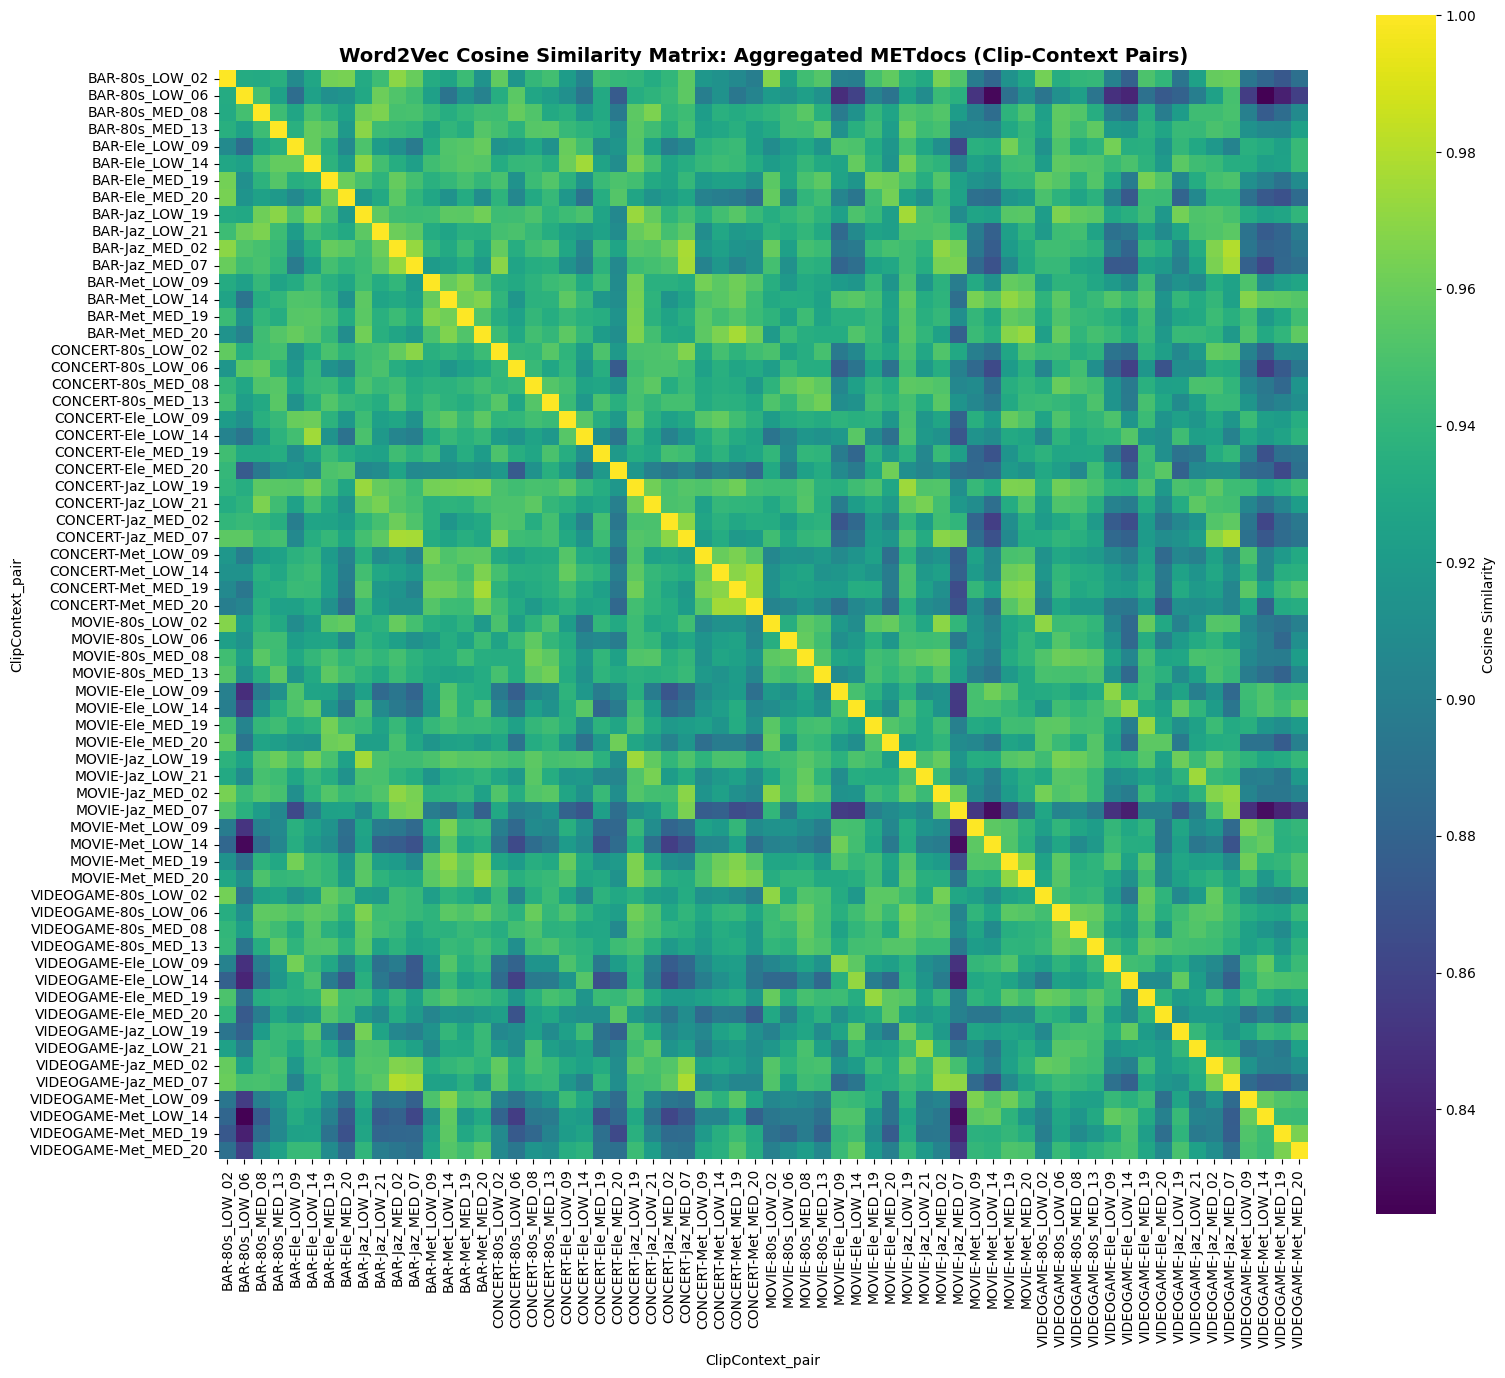

In [13]:
print("\nCalculating cosine similarity matrix...")
cosineMatrix_W2V = cosine_similarity(doc_embeddings, doc_embeddings)

# Create labeled DataFrame
cosineMatrix_W2V_df = pd.DataFrame(
    cosineMatrix_W2V,
    index=METdocs['ClipContext_pair'],
    columns=METdocs['ClipContext_pair']
)

# Save cosine similarity matrix
cosineMatrix_W2V_df.to_csv('/content/context-framed-listening/NLP_outputs/Word2Vec/METdocs_cosineMatrix_W2V.csv',
                            encoding='utf-8')

print("\nWord2Vec Cosine Similarity Matrix (METdocs level):")
display(cosineMatrix_W2V_df.head())

plt.figure(figsize=(16, 14))
sns.heatmap(cosineMatrix_W2V_df, cmap='viridis', annot=False, square=True,
            cbar_kws={'label': 'Cosine Similarity'})
plt.title('Word2Vec Cosine Similarity Matrix: Aggregated METdocs (Clip-Context Pairs)',
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/Word2Vec/METdocs_heatmap_W2V.png',
            dpi=300, bbox_inches='tight')
plt.show()


### Similarity Values by Condition

In [14]:
print("\nExtracting similarity values by condition...")
print("Using IDENTICAL conditions as individual thought-level analysis...")

# Extract metadata
clips = METdocs['clip_name'].values
contexts = METdocs['context_word'].values
genres = METdocs['genre_code'].values

# Initialise storage for similarity measures
similarity_data = {
    'doc_i': [],
    'doc_j': [],
    'similarity': [],
    'same_clip': [],
    'same_context': [],
    'same_genre': [],
    'condition': []
}

# Iterate through upper triangle of similarity matrix
n_docs = len(METdocs)
print(f"Processing {(n_docs * (n_docs - 1)) // 2} unique document pairs...")

for i in range(n_docs):
    if (i + 1) % 10 == 0:
        print(f"  Processed {i + 1}/{n_docs} documents...")

    for j in range(i + 1, n_docs):
        # Extract similarity value
        sim_value = cosineMatrix_W2V[i, j]

        # Determine conditions (IDENTICAL to individual-level analysis)
        same_clip = clips[i] == clips[j]
        same_context = contexts[i] == contexts[j]
        same_genre = genres[i] == genres[j]

        # Categorise into SAME conditions as individual thought analysis
        if same_clip and same_context:
            condition = 'same_clip_same_context'
        elif same_clip and not same_context:
            condition = 'same_clip_diff_context'  # MUSIC influence
        elif not same_clip and same_context:
            condition = 'diff_clip_same_context'  # CONTEXT influence
        elif not same_clip and not same_context:
            if same_genre:
                condition = 'diff_clip_diff_context_same_genre'
            else:
                condition = 'diff_clip_diff_context_diff_genre'

        # Store data
        similarity_data['doc_i'].append(i)
        similarity_data['doc_j'].append(j)
        similarity_data['similarity'].append(sim_value)
        similarity_data['same_clip'].append(same_clip)
        similarity_data['same_context'].append(same_context)
        similarity_data['same_genre'].append(same_genre)
        similarity_data['condition'].append(condition)

# Create DataFrame
sim_df_docs = pd.DataFrame(similarity_data)
sim_df_docs.to_csv('/content/context-framed-listening/NLP_outputs/Word2Vec/METdocs_similarity_by_condition_W2V.csv',
                    index=False)

print("\nMETdocs-level similarity measures extracted:")
print(sim_df_docs.groupby('condition')['similarity'].agg(['count', 'mean', 'std', 'min', 'max']))



Extracting similarity values by condition...
Using IDENTICAL conditions as individual thought-level analysis...
Processing 2016 unique document pairs...
  Processed 10/64 documents...
  Processed 20/64 documents...
  Processed 30/64 documents...
  Processed 40/64 documents...
  Processed 50/64 documents...
  Processed 60/64 documents...

METdocs-level similarity measures extracted:
                                   count      mean       std       min  \
condition                                                                
diff_clip_diff_context_diff_genre   1152  0.922210  0.023811  0.824647   
diff_clip_diff_context_same_genre    288  0.935814  0.020532  0.867173   
diff_clip_same_context               480  0.933283  0.021163  0.830646   
same_clip_diff_context                96  0.954884  0.014627  0.904266   

                                        max  
condition                                    
diff_clip_diff_context_diff_genre  0.968814  
diff_clip_diff_context_same_gen

### STATISTICAL ANALYSES

1. PRIMARY RESEARCH QUESTION
2. Genre Effects
3. Context Specificity
4. Music Specificity
5. OMNIBUS TEST
6. Condition Means Ranking

In [15]:
# Store all comparison results
comparisons_docs = []


# 1. PRIMARY RESEARCH QUESTION
# ---------------------------------------------------------------------------
print("\n1. PRIMARY QUESTION: Music vs Context Influence (METdocs level)")
print("-" * 70)

comp = compare_conditions(
    sim_df_docs,
    'same_clip_diff_context',
    'diff_clip_same_context',
    'Same Music, Diff Context',
    'Diff Music, Same Context'
)
comparisons_docs.append(comp)

print(f"\nSame music, different context: M={comp['mean1']:.4f} (N={comp['n1']})")
print(f"Different music, same context: M={comp['mean2']:.4f} (N={comp['n2']})")
print(f"Difference: {comp['diff']:.4f}")
print(f"t({comp['n1'] + comp['n2'] - 2}) = {comp['t']:.3f}, p = {comp['p']:.4f} {comp['sig']}")
print(f"Cohen's d = {comp['d']:.3f}")

if comp['mean1'] > comp['mean2']:
    print("\n→ At METdocs level: MUSIC drives similarity MORE than context")
else:
    print("\n→ At METdocs level: CONTEXT drives similarity MORE than music")


# 2. GENRE EFFECTS
# ---------------------------------------------------------------------------
print("\n\n2. GENRE EFFECTS (METdocs level)")
print("-" * 70)

comp = compare_conditions(
    sim_df_docs,
    'diff_clip_diff_context_same_genre',
    'diff_clip_diff_context_diff_genre',
    'Different everything, Same Genre',
    'Different everything, Different Genre'
)
comparisons_docs.append(comp)

print(f"\nSame genre (diff clip & context): M={comp['mean1']:.4f} (N={comp['n1']})")
print(f"Different genre (diff clip & context): M={comp['mean2']:.4f} (N={comp['n2']})")
print(f"t = {comp['t']:.3f}, p = {comp['p']:.4f} {comp['sig']}, d = {comp['d']:.3f}")

if comp['sig'] != 'n.s.':
    print("\n→ Genre creates semantic coherence at document level")
else:
    print("\n→ Genre does NOT significantly affect document-level similarity")


# 3. CONTEXT SPECIFICITY
# ---------------------------------------------------------------------------
print("\n\n3. CONTEXT SPECIFICITY (METdocs level)")
print("-" * 70)

comp = compare_conditions(
    sim_df_docs,
    'same_clip_same_context',
    'diff_clip_same_context',
    'Same Context & Same Clip',
    'Same Context, Diff Clip'
)
comparisons_docs.append(comp)

print(f"\nSame context + same clip: M={comp['mean1']:.4f} (N={comp['n1']})")
print(f"Same context, different clip: M={comp['mean2']:.4f} (N={comp['n2']})")
print(f"t = {comp['t']:.3f}, p = {comp['p']:.4f} {comp['sig']}, d = {comp['d']:.3f}")


# 4. MUSIC SPECIFICITY
# ---------------------------------------------------------------------------
print("\n\n4. MUSIC SPECIFICITY (METdocs level)")
print("-" * 70)

comp = compare_conditions(
    sim_df_docs,
    'same_clip_same_context',
    'same_clip_diff_context',
    'Same Clip & Same Context',
    'Same Clip, Diff Context'
)
comparisons_docs.append(comp)

print(f"\nSame clip + same context: M={comp['mean1']:.4f} (N={comp['n1']})")
print(f"Same clip, different context: M={comp['mean2']:.4f} (N={comp['n2']})")
print(f"t = {comp['t']:.3f}, p = {comp['p']:.4f} {comp['sig']}, d = {comp['d']:.3f}")


# 5. OMNIBUS TEST
# ---------------------------------------------------------------------------
print("\n\n5. OMNIBUS TEST: Do conditions differ overall? (METdocs level)")
print("-" * 70)

conditions_docs = sim_df_docs['condition'].unique()
groups_docs = [sim_df_docs[sim_df_docs['condition'] == cond]['similarity'] for cond in conditions_docs]
f_stat_docs, p_anova_docs = stats.f_oneway(*groups_docs)

print(f"\nOne-way ANOVA across all {len(conditions_docs)} conditions:")
print(f"F({len(conditions_docs)-1}, {len(sim_df_docs)-len(conditions_docs)}) = {f_stat_docs:.3f}, p = {p_anova_docs:.4e}")

if p_anova_docs < 0.001:
    print("\n→ Conditions are HIGHLY significantly different at document level")
else:
    print("\n→ Conditions show significant differences" if p_anova_docs < 0.05 else "→ No significant differences")


# 6. CONDITION MEANS RANKING
# ---------------------------------------------------------------------------
print("\n\n6. CONDITION MEANS RANKING (METdocs level)")
print("-" * 70)

condition_means_docs = sim_df_docs.groupby('condition')['similarity'].agg(['mean', 'std', 'count'])
condition_means_docs = condition_means_docs.sort_values('mean', ascending=False)

print("\nCondition means (ranked):")
print(condition_means_docs)


# Save comparison results
comparisons_df_docs = pd.DataFrame(comparisons_docs)
comparisons_df_docs = comparisons_df_docs.sort_values('d', key=abs, ascending=False)
comparisons_df_docs.to_csv('/content/context-framed-listening/NLP_outputs/Word2Vec/METdocs_statistical_comparisons_W2V.csv',
                            index=False)

print("\n\nKey comparisons ranked by effect size:")
print(comparisons_df_docs[['comparison', 'diff', 'd', 'p', 'sig']])



1. PRIMARY QUESTION: Music vs Context Influence (METdocs level)
----------------------------------------------------------------------

Same music, different context: M=0.9549 (N=96)
Different music, same context: M=0.9333 (N=480)
Difference: 0.0216
t(574) = 9.551, p = 0.0000 ***
Cohen's d = 1.187

→ At METdocs level: MUSIC drives similarity MORE than context


2. GENRE EFFECTS (METdocs level)
----------------------------------------------------------------------

Same genre (diff clip & context): M=0.9358 (N=288)
Different genre (diff clip & context): M=0.9222 (N=1152)
t = 8.903, p = 0.0000 ***, d = 0.612

→ Genre creates semantic coherence at document level


3. CONTEXT SPECIFICITY (METdocs level)
----------------------------------------------------------------------

Same context + same clip: M=nan (N=0)
Same context, different clip: M=0.9333 (N=480)
t = nan, p = nan n.s., d = nan


4. MUSIC SPECIFICITY (METdocs level)
---------------------------------------------------------------

/usr/local/lib/python3.12/dist-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)


### Visualisations

1. PRIMARY COMPARISON: Music vs Context
2. ALL CONDITIONS comparison
3. Bar plot with means and 95% CI
4. Distribution comparison histogram
5. HIERARCHICAL comparison
6. Genre effects visualisation
7. Heatmap


Generating visualisations...


/tmp/ipython-input-1753853562.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Same Music\nDifferent Context', 'Different Music\nSame Context'])


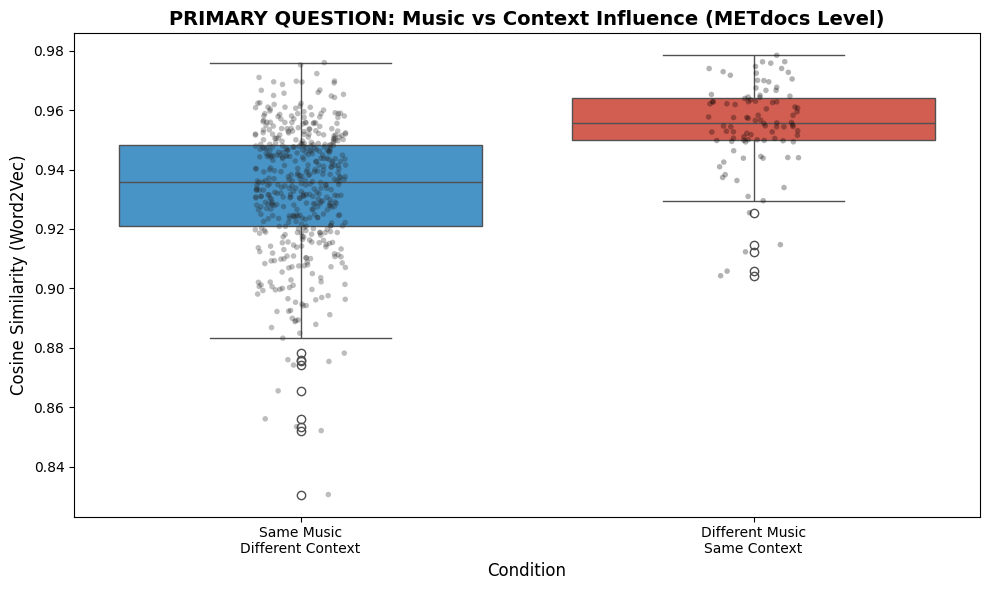

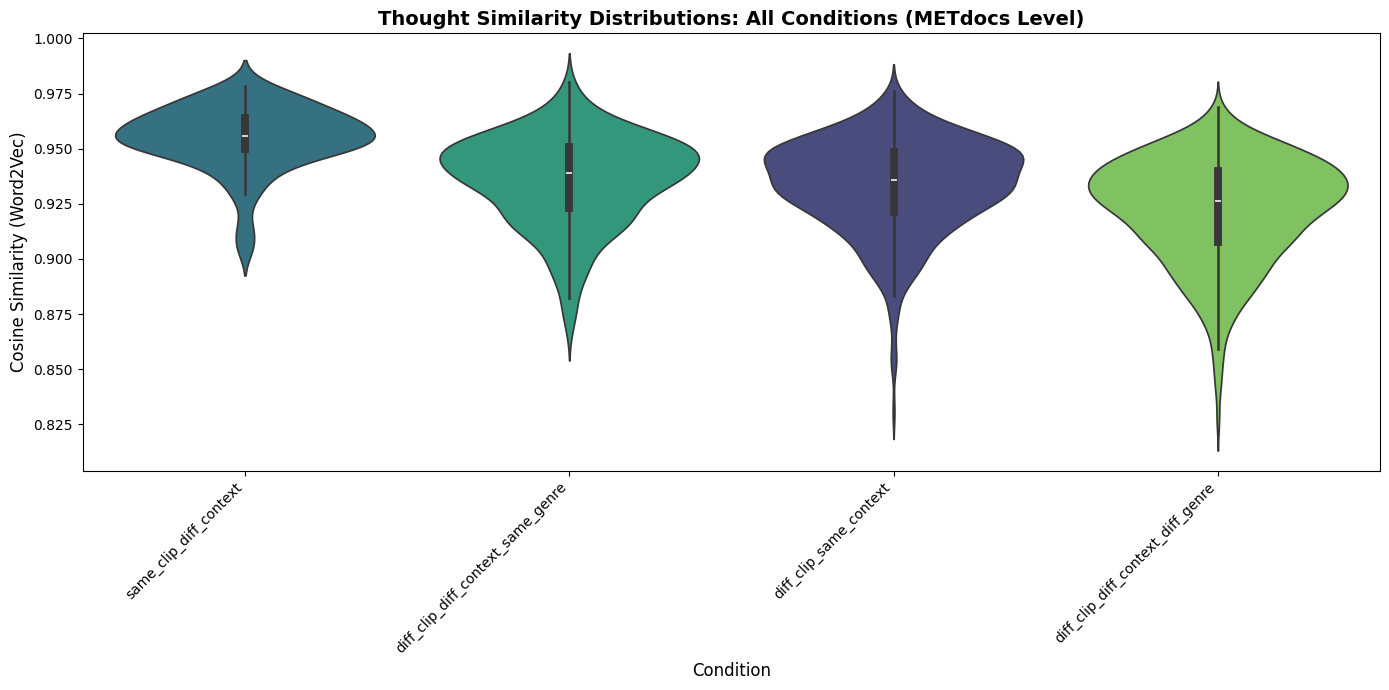

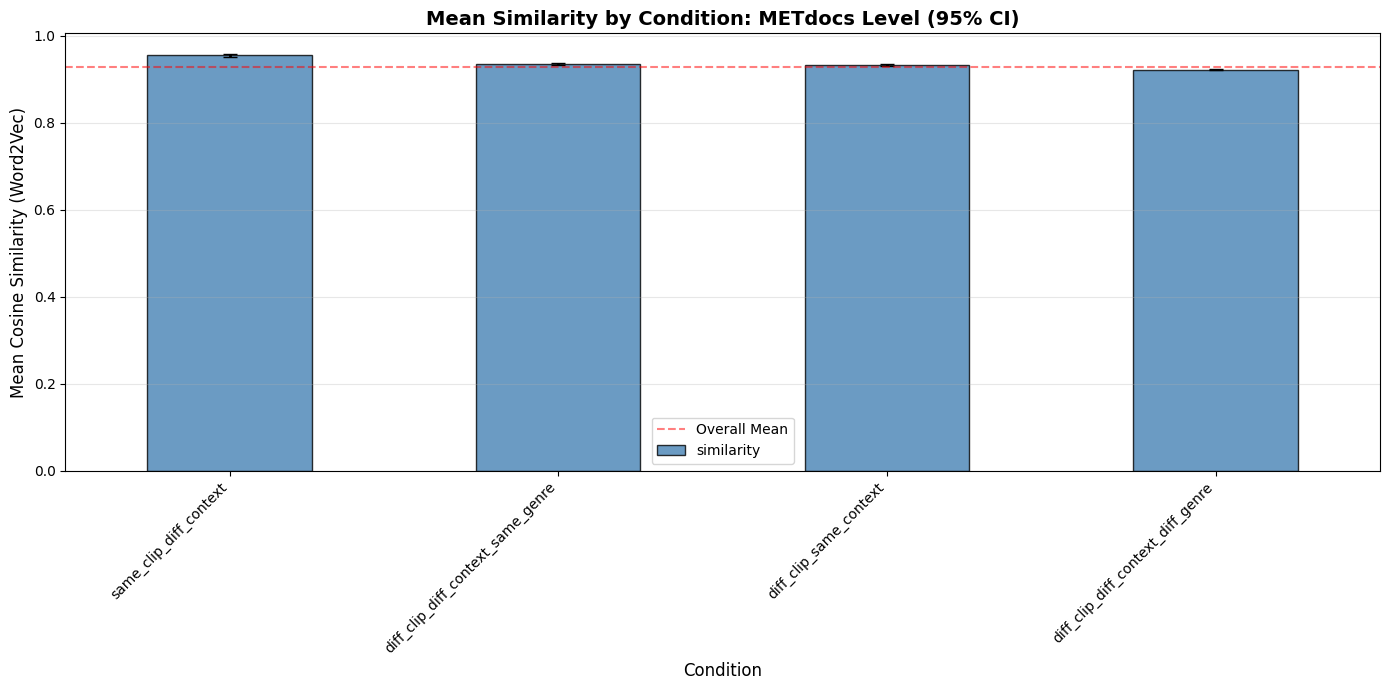

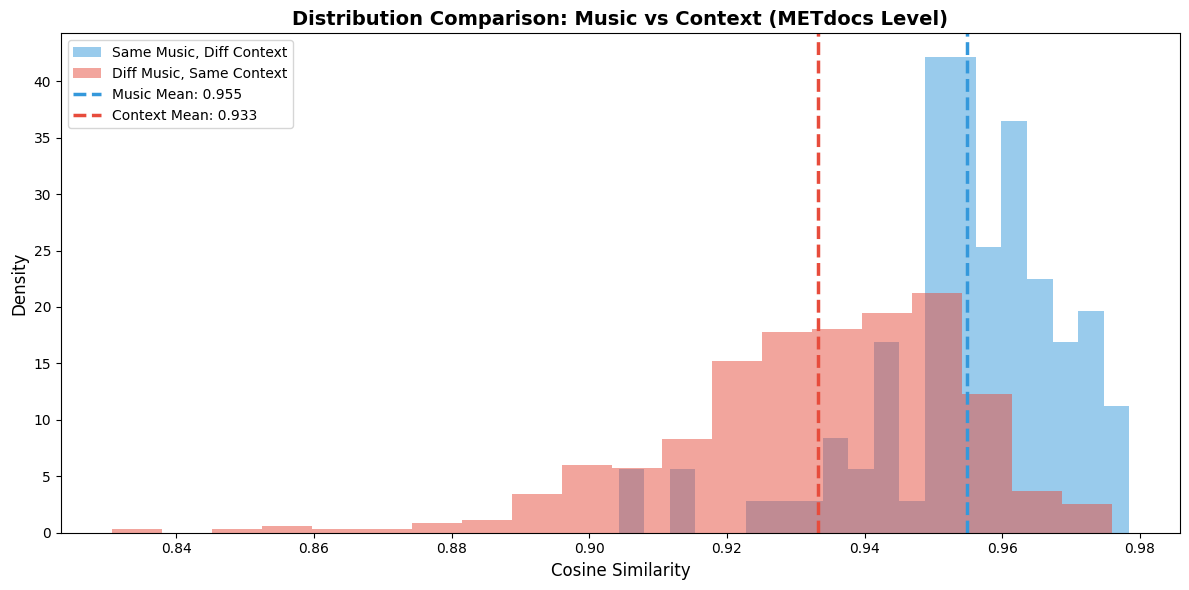

/tmp/ipython-input-1753853562.py:106: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=0, ha='center')


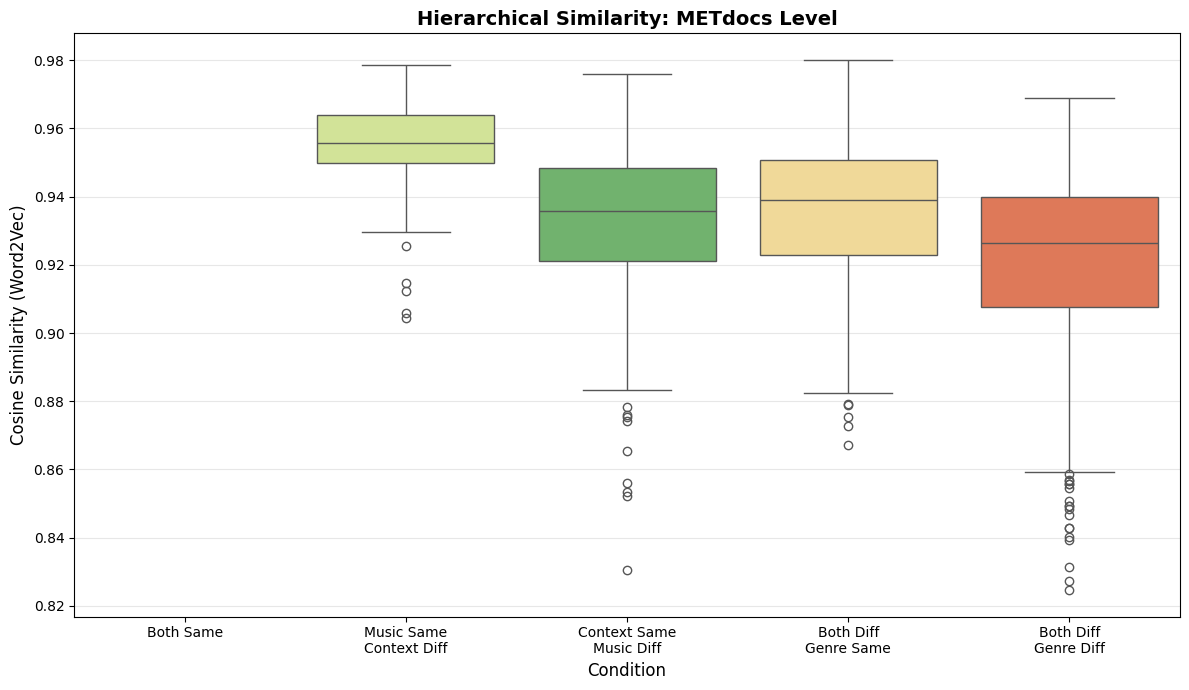

/tmp/ipython-input-1753853562.py:128: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['Same Genre', 'Different Genre'])


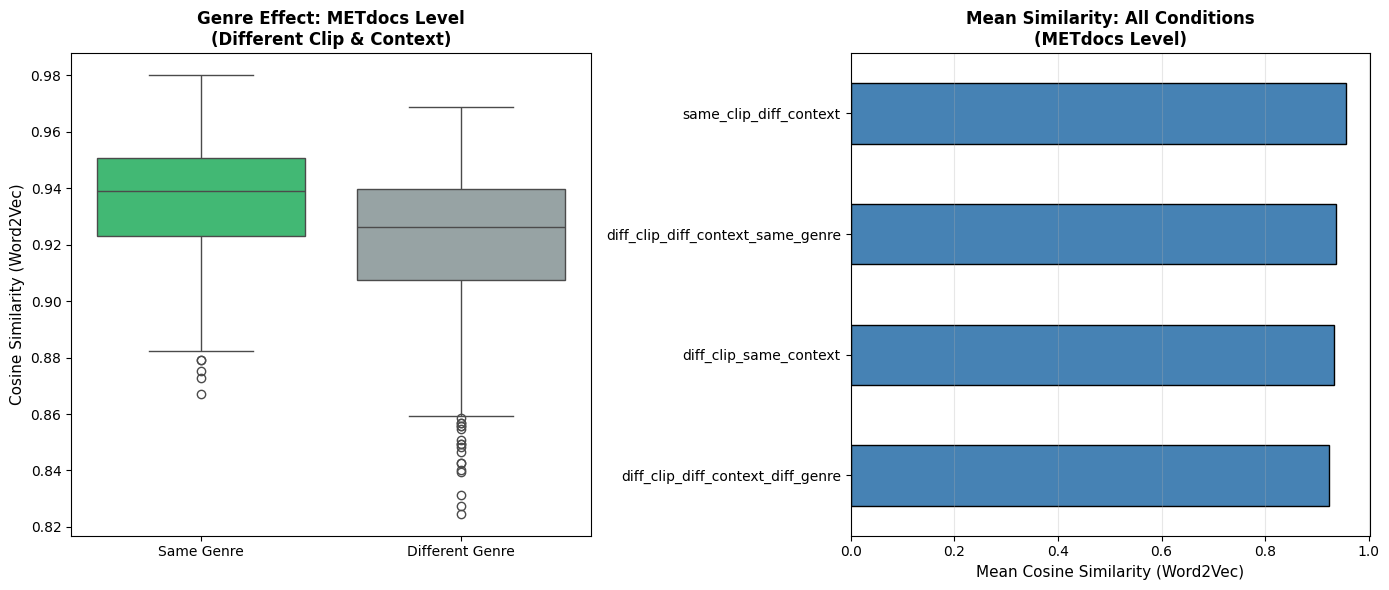

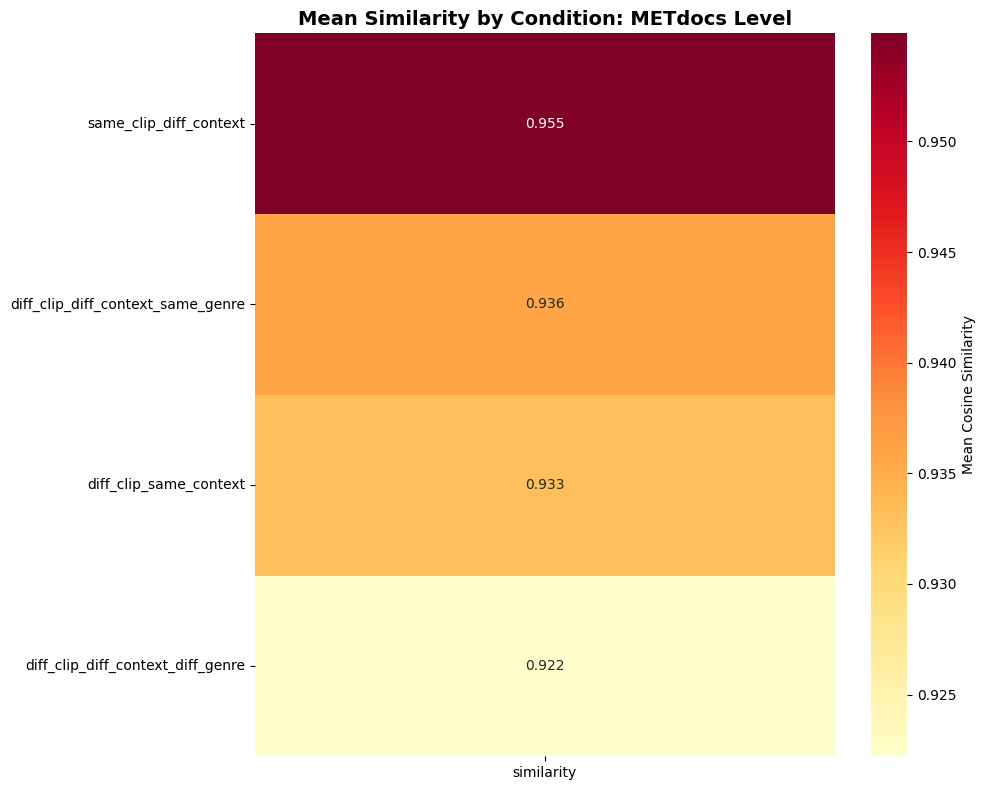

In [16]:
print("\nGenerating visualisations...")

# Get data for key conditions
music_driven_docs = sim_df_docs[sim_df_docs['condition'] == 'same_clip_diff_context']['similarity']
context_driven_docs = sim_df_docs[sim_df_docs['condition'] == 'diff_clip_same_context']['similarity']
same_both_docs = sim_df_docs[sim_df_docs['condition'] == 'same_clip_same_context']['similarity']
diff_both_same_genre_docs = sim_df_docs[sim_df_docs['condition'] == 'diff_clip_diff_context_same_genre']['similarity']
diff_both_diff_genre_docs = sim_df_docs[sim_df_docs['condition'] == 'diff_clip_diff_context_diff_genre']['similarity']


# 1. PRIMARY COMPARISON: Music vs Context
fig, ax = plt.subplots(figsize=(10, 6))
comparison_data = sim_df_docs[sim_df_docs['condition'].isin(['same_clip_diff_context', 'diff_clip_same_context'])]
sns.boxplot(data=comparison_data, x='condition', y='similarity', ax=ax,
            hue='condition', palette=['#3498db', '#e74c3c'])
sns.stripplot(data=comparison_data, x='condition', y='similarity', ax=ax,
              hue='condition', palette='dark:black', alpha=0.3, size=4)
ax.set_title('PRIMARY QUESTION: Music vs Context Influence (METdocs Level)',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Condition', fontsize=12)
ax.set_ylabel('Cosine Similarity (Word2Vec)', fontsize=12)
ax.set_xticklabels(['Same Music\nDifferent Context', 'Different Music\nSame Context'])
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/Word2Vec/METdocs_01_music_vs_context_boxplot_W2V.png',
            dpi=300, bbox_inches='tight')
plt.show()


# 2. ALL CONDITIONS comparison
fig, ax = plt.subplots(figsize=(14, 7))
condition_order = sim_df_docs.groupby('condition')['similarity'].mean().sort_values(ascending=False).index
sns.violinplot(data=sim_df_docs, x='condition', y='similarity', ax=ax, order=condition_order,
               hue='condition', palette='viridis')
ax.set_title('Thought Similarity Distributions: All Conditions (METdocs Level)',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Condition', fontsize=12)
ax.set_ylabel('Cosine Similarity (Word2Vec)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/Word2Vec/METdocs_02_all_conditions_violin_W2V.png',
            dpi=300, bbox_inches='tight')
plt.show()


# 3. Bar plot with means and 95% CI
fig, ax = plt.subplots(figsize=(14, 7))
means = sim_df_docs.groupby('condition')['similarity'].mean().sort_values(ascending=False)
sems = sim_df_docs.groupby('condition')['similarity'].sem()
ci95 = sems * 1.96

means.plot(kind='bar', ax=ax, yerr=ci95, capsize=5, color='steelblue',
           edgecolor='black', alpha=0.8, error_kw={'linewidth': 2})
ax.set_title('Mean Similarity by Condition: METdocs Level (95% CI)',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Condition', fontsize=12)
ax.set_ylabel('Mean Cosine Similarity (Word2Vec)', fontsize=12)
ax.set_xticklabels(means.index, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)
ax.axhline(y=sim_df_docs['similarity'].mean(), color='red', linestyle='--',
           alpha=0.5, label='Overall Mean')
ax.legend()
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/Word2Vec/METdocs_03_condition_means_barplot_W2V.png',
            dpi=300, bbox_inches='tight')
plt.show()


# 4. Distribution comparison histogram
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(music_driven_docs, bins=20, alpha=0.5, label='Same Music, Diff Context',
        color='#3498db', density=True)
ax.hist(context_driven_docs, bins=20, alpha=0.5, label='Diff Music, Same Context',
        color='#e74c3c', density=True)
ax.axvline(music_driven_docs.mean(), color='#3498db', linestyle='--', linewidth=2.5,
           label=f'Music Mean: {music_driven_docs.mean():.3f}')
ax.axvline(context_driven_docs.mean(), color='#e74c3c', linestyle='--', linewidth=2.5,
           label=f'Context Mean: {context_driven_docs.mean():.3f}')
ax.set_xlabel('Cosine Similarity', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Distribution Comparison: Music vs Context (METdocs Level)',
             fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/Word2Vec/METdocs_04_music_vs_context_histogram_W2V.png',
            dpi=300, bbox_inches='tight')
plt.show()


# 5. HIERARCHICAL comparison
fig, ax = plt.subplots(figsize=(12, 7))
hierarchical_data = sim_df_docs[sim_df_docs['condition'].isin([
    'same_clip_same_context',
    'same_clip_diff_context',
    'diff_clip_same_context',
    'diff_clip_diff_context_same_genre',
    'diff_clip_diff_context_diff_genre'
])]

order = ['same_clip_same_context', 'same_clip_diff_context', 'diff_clip_same_context',
         'diff_clip_diff_context_same_genre', 'diff_clip_diff_context_diff_genre']
labels = ['Both Same', 'Music Same\nContext Diff', 'Context Same\nMusic Diff',
          'Both Diff\nGenre Same', 'Both Diff\nGenre Diff']

sns.boxplot(data=hierarchical_data, x='condition', y='similarity', ax=ax,
            order=order, hue='condition', palette='RdYlGn_r')
ax.set_xticklabels(labels, rotation=0, ha='center')
ax.set_title('Hierarchical Similarity: METdocs Level', fontsize=14, fontweight='bold')
ax.set_xlabel('Condition', fontsize=12)
ax.set_ylabel('Cosine Similarity (Word2Vec)', fontsize=12)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/Word2Vec/METdocs_05_hierarchical_comparison_W2V.png',
            dpi=300, bbox_inches='tight')
plt.show()


# 6. Genre effects visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

genre_comparison = sim_df_docs[sim_df_docs['condition'].isin([
    'diff_clip_diff_context_same_genre',
    'diff_clip_diff_context_diff_genre'
])]
sns.boxplot(data=genre_comparison, x='condition', y='similarity', ax=axes[0],
            hue='condition', palette=['#2ecc71', '#95a5a6'])
axes[0].set_title('Genre Effect: METdocs Level\n(Different Clip & Context)',
                  fontsize=12, fontweight='bold')
axes[0].set_xticklabels(['Same Genre', 'Different Genre'])
axes[0].set_ylabel('Cosine Similarity (Word2Vec)', fontsize=11)
axes[0].set_xlabel('')

all_conditions_means = sim_df_docs.groupby('condition')['similarity'].mean()
all_conditions_means.sort_values(ascending=True).plot(kind='barh', ax=axes[1],
                                                       color='steelblue', edgecolor='black')
axes[1].set_title('Mean Similarity: All Conditions\n(METdocs Level)',
                  fontsize=12, fontweight='bold')
axes[1].set_xlabel('Mean Cosine Similarity (Word2Vec)', fontsize=11)
axes[1].set_ylabel('')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/Word2Vec/METdocs_06_genre_effects_summary_W2V.png',
            dpi=300, bbox_inches='tight')
plt.show()


# 7. Heatmap
fig, ax = plt.subplots(figsize=(10, 8))
condition_pivot = sim_df_docs.pivot_table(values='similarity',
                                           index='condition',
                                           aggfunc='mean').sort_values('similarity', ascending=False)
sns.heatmap(condition_pivot, annot=True, fmt='.3f', cmap='YlOrRd',
            cbar_kws={'label': 'Mean Cosine Similarity'}, ax=ax)
ax.set_title('Mean Similarity by Condition: METdocs Level', fontsize=14, fontweight='bold')
ax.set_ylabel('')
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/Word2Vec/METdocs_07_condition_heatmap_W2V.png',
            dpi=300, bbox_inches='tight')
plt.show()


### SUMMARY

In [17]:
print("\n" + "-"*70)
print("METDOCS-LEVEL ANALYSIS COMPLETE")
print("-"*70)

print("\nOutput files saved:")
print("  Data files:")
print("    - METdocs_embeddings_W2V.npy")
print("    - METdocs_cosineMatrix_W2V.csv")
print("    - METdocs_similarity_by_condition_W2V.csv")
print("    - METdocs_statistical_comparisons_W2V.csv")

print("\n  Visualisations:")
print("    - METdocs_heatmap_W2V.png")
print("    - METdocs_01_music_vs_context_boxplot_W2V.png")
print("    - METdocs_02_all_conditions_violin_W2V.png")
print("    - METdocs_03_condition_means_barplot_W2V.png")
print("    - METdocs_04_music_vs_context_histogram_W2V.png")
print("    - METdocs_05_hierarchical_comparison_W2V.png")
print("    - METdocs_06_genre_effects_summary_W2V.png")
print("    - METdocs_07_condition_heatmap_W2V.png")

print("\n" + "-"*70)
print("KEY FINDINGS SUMMARY (METdocs Level)")
print("-"*70)

music_driven_summary = sim_df_docs[sim_df_docs['condition'] == 'same_clip_diff_context']['similarity']
context_driven_summary = sim_df_docs[sim_df_docs['condition'] == 'diff_clip_same_context']['similarity']
diff = music_driven_summary.mean() - context_driven_summary.mean()
t_stat, p_value = stats.ttest_ind(music_driven_summary, context_driven_summary)
effect_size = diff / np.sqrt((music_driven_summary.std()**2 + context_driven_summary.std()**2) / 2)

print("\n1. PRIMARY RESEARCH QUESTION: Music vs Context (METdocs level)")
if abs(diff) < 0.01:
    print(f"   → Music and context have EQUIVALENT influence (d={effect_size:.3f})")
elif music_driven_summary.mean() > context_driven_summary.mean():
    print(f"   → MUSIC drives similarity MORE than context")
    print(f"   → Difference: {diff:.4f} (d={effect_size:.3f}, p={p_value:.4f})")
else:
    print(f"   → CONTEXT drives similarity MORE than music")
    print(f"   → Difference: {abs(diff):.4f} (d={abs(effect_size):.3f}, p={p_value:.4f})")

same_genre = sim_df_docs[sim_df_docs['condition'] == 'diff_clip_diff_context_same_genre']['similarity'].mean()
diff_genre = sim_df_docs[sim_df_docs['condition'] == 'diff_clip_diff_context_diff_genre']['similarity'].mean()
print(f"\n2. GENRE EFFECTS (METdocs level)")
print(f"   → Same genre: M={same_genre:.4f}")
print(f"   → Different genre: M={diff_genre:.4f}")
print(f"   → Difference: {same_genre - diff_genre:.4f}")

if len(same_both_docs) > 0:
    print(f"\n3. BASELINE (identical clip-context pairs)")
    print(f"   → Note: Same clip + same context = same document (N={len(same_both_docs)})")
    print(f"   → Mean similarity: {same_both_docs.mean():.4f}")

print("\n" + "-"*70)
print("COMPARISON NOTE:")
print("-"*70)
print("This METdocs analysis uses IDENTICAL condition categories as the")
print("individual thought-level analysis, enabling direct comparison of:")
print("  - Effect sizes (Cohen's d)")
print("  - Condition rankings")
print("  - Statistical significance patterns")
print("\nKey differences:")
print("  - METdocs: N documents = ~64 (clip-context pairs)")
print("  - Individual: N pairs = ~1.9 million (all thought pairs)")
print("  - METdocs: Shows condition-level semantic profiles")
print("  - Individual: Shows individual-level variability and patterns")
print("\nUse both analyses together to understand patterns at different scales")
print("~"*70)


----------------------------------------------------------------------
METDOCS-LEVEL ANALYSIS COMPLETE
----------------------------------------------------------------------

Output files saved:
  Data files:
    - METdocs_embeddings_W2V.npy
    - METdocs_cosineMatrix_W2V.csv
    - METdocs_similarity_by_condition_W2V.csv
    - METdocs_statistical_comparisons_W2V.csv

  Visualisations:
    - METdocs_heatmap_W2V.png
    - METdocs_01_music_vs_context_boxplot_W2V.png
    - METdocs_02_all_conditions_violin_W2V.png
    - METdocs_03_condition_means_barplot_W2V.png
    - METdocs_04_music_vs_context_histogram_W2V.png
    - METdocs_05_hierarchical_comparison_W2V.png
    - METdocs_06_genre_effects_summary_W2V.png
    - METdocs_07_condition_heatmap_W2V.png

----------------------------------------------------------------------
KEY FINDINGS SUMMARY (METdocs Level)
----------------------------------------------------------------------

1. PRIMARY RESEARCH QUESTION: Music vs Context (METdocs level)
